In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.integrate import odeint
import seaborn as sns
from copy import deepcopy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from scipy.interpolate import CubicSpline
import warnings
warnings.filterwarnings("ignore")

# Schematic illustration

In [2]:
def scfa(y, t, k, r, K, a, b, Kb):
    prod,deg,scfa = y
    dydt = [-k*prod, r*deg*(1-deg/K), a*prod-b*deg*scfa/(scfa+Kb)]
    return dydt

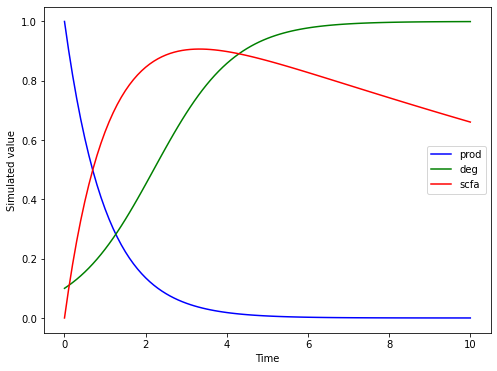

In [3]:
fig, ax = plt.subplots(figsize=(8,6), nrows=1, ncols=1, sharex=True, sharey=True)
y0=[1,0.1,0]
t = np.linspace(0, 10, 101)
k = 1
r = 1
K = 1
a = 1
b = 0.1
Kb = 1
sol = odeint(scfa, y0, t, args=(k, r, K, a, b, Kb))
plt.plot(t, sol[:, 0], 'b', label='prod')
plt.plot(t, sol[:, 1], 'g', label='deg')
plt.plot(t, sol[:, 2], 'r', label='scfa')
plt.xlabel('Time')
plt.ylabel('Simulated value')
plt.legend()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("simulated_biphasic_fermentation.svg", format="svg")

# Plot positively and negatively associated taxa

In [4]:
df_16S = pd.read_excel('../../../../../../data/16S_absolute_abundance.xlsx', index_col=0)
df_16S.columns = [c.replace('/','_slash_').replace(' ','_space_').replace('[','_leftsquarebracket_').replace(']','_rightsquarebracket_').replace('-','_dash_').replace('.','_dot_').replace('(','_leftroundbracket').replace(')','_rightroundbracket_') for c in df_16S.columns]
df_16S.head()

,A2,ASF356,Acetatifactor,Acetatifactor_dash_muris,Acidovorax,Acinetobacter,Acinetobacter_dash_sp_dot__dash_CIP_dash_56_dot_2,Acutalibacter_dash_muris,Adlercreutzia_dash_mucosicola,Adlercreutzia_dash_muris,...,_leftsquarebracket_Eubacterium_rightsquarebracket__dash_ventriosum_dash_group,_leftsquarebracket_Eubacterium_rightsquarebracket__dash_xylanophilum_dash_group,_leftsquarebracket_Ruminococcus_rightsquarebracket__dash_gnavus_dash_group,_leftsquarebracket_Ruminococcus_rightsquarebracket__dash_torques_dash_group,bacterium_dash_enrichment_dash_culture_dash_clone_dash_M153,gut_dash_metagenome,human_dash_gut_dash_metagenome,marine_dash_metagenome,metagenome,mouse_dash_gut_dash_metagenome
SampleID,,,,,,,,,,,,,,,,,,,,,
sample131,0.0,108301.701888,7101.750943,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,63028.039623,0.0,0.0,0.0,165115.709436,0.0,0.0,0.0,1.322701e+05
sample132,0.0,405068.034693,50064.588558,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,80103.341692,0.0,0.0,0.0,106501.033841,0.0,0.0,0.0,1.003112e+06
sample133,0.0,36169.603950,45332.570284,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,221840.237562,0.0,0.0,0.0,1.866352e+05
sample134,0.0,484302.054587,10150.043060,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,105850.449056,0.0,0.0,0.0,919303.900024,0.0,0.0,0.0,8.714537e+05
sample135,0.0,91489.970533,42374.302141,0.0,0.0,0.0,0.0,0.0,12519.680178,0.0,...,0.0,0.000000,0.0,0.0,0.0,581683.602124,0.0,0.0,0.0,5.335310e+05


In [5]:
df_rf = pd.read_excel('rf_importance_top40.xlsx', index_col=0)
df_elasnet = pd.read_excel('elasticnet_summary_top40.xlsx', index_col=0)
df_joined = pd.merge(df_rf, df_elasnet, left_on=['SCFA','Variable'], right_on=['SCFA','Variable'], how='inner')
df_joined.columns = ['SCFA','Taxon','RandomForest','ElasticNet']
df_joined['Type'] = 'Producer'
df_joined.loc[df_joined.ElasticNet<0,'Type'] = 'Consumer'
df_joined.head()

,SCFA,Taxon,RandomForest,ElasticNet,Type
0,Acetate,Muribaculaceae,0.011586,-5.597753,Consumer
1,Acetate,Akkermansia_dash_muciniphila,0.006559,5.591412,Producer
2,Acetate,Bacteroides_dash_acidifaciens,0.012089,-0.877916,Consumer
3,Acetate,Faecalibaculum,0.018849,-12.674858,Consumer
4,Acetate,Parasutterella,0.103895,-10.894415,Consumer


In [6]:
df_joined[(df_joined.SCFA=='Propionate') & (df_joined.Type=='Consumer')].sort_values(by='RandomForest', ascending=False)

,SCFA,Taxon,RandomForest,ElasticNet,Type
111,Propionate,Desulfovibrionaceae,0.040344,-150.118990,Consumer
118,Propionate,Candidatus_dash_Saccharimonas,0.024491,-391.663246,Consumer
110,Propionate,Muribaculum,0.021441,-875.720484,Consumer
82,Propionate,Bacteroides_dash_acidifaciens,0.020039,-1.046617,Consumer
80,Propionate,Muribaculaceae,0.015750,-6.166626,Consumer
93,Propionate,Mucispirillum_dash_schaedleri,0.015182,-83.768932,Consumer
86,Propionate,Bacteroides,0.015095,-7.956589,Consumer
109,Propionate,Peptococcaceae,0.014866,-175.727087,Consumer
106,Propionate,mouse_dash_gut_dash_metagenome,0.014535,-57.302775,Consumer
99,Propionate,Roseburia,0.013709,-117.317566,Consumer


In [7]:
df_16S_meta = pd.read_excel('../../../../../../data/meta_data.xlsx', index_col=0)
df_16S_meta = df_16S_meta[(df_16S_meta.Diet=='Inulin') & (df_16S_meta.Vendor!='Guangdong')]
for scfa in ['Acetate','Butyrate','Propionate']:
    df_16S_scfa_producer = deepcopy(df_16S)
    df_16S_scfa_consumer = deepcopy(df_16S)
    df_16S_scfa_producer = df_16S_scfa_producer[list(df_joined.loc[(df_joined.SCFA==scfa)&(df_joined.Type=='Producer'),'Taxon'])]
    df_16S_scfa_consumer = df_16S_scfa_consumer[list(df_joined.loc[(df_joined.SCFA==scfa)&(df_joined.Type=='Consumer'),'Taxon'])]
    for c in df_16S_scfa_producer.columns:
        df_16S_scfa_producer[c] *= list(df_joined.loc[(df_joined.SCFA==scfa) & (df_joined.Taxon==c), 'RandomForest'])[0]
    for c in df_16S_scfa_consumer.columns:
        df_16S_scfa_consumer[c] *= list(df_joined.loc[(df_joined.SCFA==scfa) & (df_joined.Taxon==c), 'RandomForest'])[0]
    df_16S_scfa_producer = df_16S_scfa_producer.sum(axis=1).to_frame()
    df_16S_scfa_producer.columns = [scfa+'_Producer']
    df_16S_scfa_consumer = df_16S_scfa_consumer.sum(axis=1).to_frame()
    df_16S_scfa_consumer.columns = [scfa+'_Consumer']
    df_16S_meta = pd.merge(df_16S_meta, df_16S_scfa_producer, left_index=True, right_index=True, how='inner')
    df_16S_meta = pd.merge(df_16S_meta, df_16S_scfa_consumer, left_index=True, right_index=True, how='inner')
df_16S_meta.head()

,MiceID,Vendor,Day,Diet,Acetate_Producer,Acetate_Consumer,Butyrate_Producer,Butyrate_Consumer,Propionate_Producer,Propionate_Consumer
SampleID,,,,,,,,,,
sample141,BI1,Beijing,0,Inulin,2.983983e+05,1.299769e+06,2.725345e+05,4.421645e+06,1.080032e+06,4.872107e+05
sample142,BI2,Beijing,0,Inulin,9.409727e+05,5.533824e+05,7.928635e+05,1.783762e+06,8.961577e+05,2.686687e+05
sample143,BI3,Beijing,0,Inulin,1.656084e+06,8.419392e+05,1.162754e+06,2.823440e+06,3.158395e+06,1.272647e+06
sample144,BI4,Beijing,0,Inulin,5.413853e+05,6.222802e+05,3.544419e+05,2.169500e+06,8.856420e+05,1.892513e+06
sample145,BI5,Beijing,0,Inulin,8.728579e+05,9.255586e+05,6.290890e+05,4.365488e+06,1.797604e+06,1.613170e+06


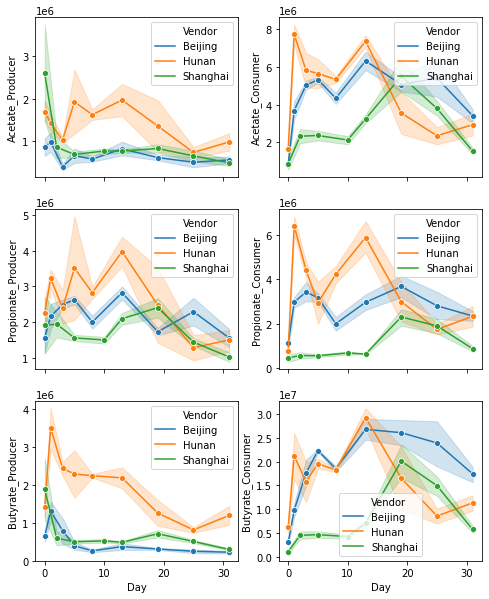

In [8]:
fig, ax = plt.subplots(figsize=(8,10), nrows=3, ncols=2, sharex=True)
for i,scfa in enumerate(['Acetate','Propionate','Butyrate']):
    for j,mtype in enumerate(['Producer','Consumer']):
        sns.lineplot(x='Day',y=scfa+'_'+mtype,hue='Vendor',marker='o',ci=68,data=df_16S_meta,ax=ax[i,j])
        #ax[i,j].set_yscale('log')
        #ax[j,i].set_ylim([2e5,5e7])
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("grouped_scfa_producer_consumer.svg", format="svg")

# Plot most significant SCFA producer

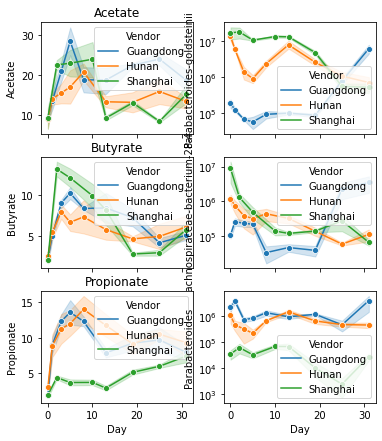

In [6]:
df_16S = pd.read_excel('../../../../../data/16S_absolute_abundance.xlsx', index_col=0)
df_meta = pd.read_excel('../../../../../data/meta_data.xlsx', index_col=0)
df_16S_meta= pd.merge(df_meta, df_16S, left_index=True, right_index=True, how='inner')
df_16S_meta = df_16S_meta[(df_16S_meta.Diet=='Inulin') & (df_16S_meta.Vendor!='Beijing') & (df_16S_meta.Day<=500)]
#df_16S_meta.loc[df_16S_meta.Vendor!='Shanghai','Vendor'] = 'Other'

# df_qpcr = pd.read_excel('../../../../data/qPCR.xlsx', index_col=0)
# df_qpcr_meta= pd.merge(df_meta, df_qpcr, left_index=True, right_index=True, how='inner')
# df_qpcr_meta = df_qpcr_meta[(df_qpcr_meta.Diet=='Inulin') & (df_qpcr_meta.Vendor!='Beijing')]

df_scfa = pd.read_excel('../../../../../data/SCFA.xlsx', index_col=0)
df_scfa_meta= pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')
df_scfa_meta = df_scfa_meta[(df_scfa_meta.Diet=='Inulin') & (df_scfa_meta.Vendor!='Beijing') & (df_scfa_meta.Day<=500)]
#df_scfa_meta.loc[df_scfa_meta.Vendor!='Shanghai','Vendor'] = 'Other'

fig, ax = plt.subplots(figsize=(6,7), nrows=3, ncols=2, sharex=True)
for k,scfa in enumerate(['Acetate','Butyrate','Propionate']):
    if scfa == 'Acetate':
        producer = 'Parabacteroides-goldsteinii'
    if scfa == 'Butyrate':
        producer = 'Lachnospiraceae-bacterium-28-4'
    if scfa == 'Propionate':
        producer = 'Parabacteroides'
    
    sns.lineplot(x='Day',y=scfa, marker='o', hue='Vendor', ci=68, data=df_scfa_meta, ax=ax[k,0])
    #sns.lineplot(x='Day',y='Value', marker='o', hue='Vendor', ci=68, data=df_qpcr_meta, ax=ax[1,k])
    sns.lineplot(x='Day',y=producer, marker='o', hue='Vendor', ci=68, data=df_16S_meta, ax=ax[k,1])
    ax[k,0].set_title(scfa)
    ax[k,1].set_yscale('log')
    ax[k,1].minorticks_off()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("topscfa_producer.svg", format="svg")

# Prediction using Hunan data

In [5]:
df_scfa = pd.read_excel('../../../../../../data/SCFA.xlsx', index_col=0)
df_scfa = df_scfa[['Acetate','Butyrate','Propionate']]
df_meta = pd.read_excel('../../../../../../data/meta_data.xlsx', index_col=0)
df_scfa_meta = pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')
df_scfa_meta = df_scfa_meta[df_scfa_meta.Diet=='Inulin']
df_scfa_meta.head()

,MiceID,Vendor,Day,Diet,Acetate,Butyrate,Propionate
SampleID,,,,,,,
sample141,BI1,Beijing,0,Inulin,5.233899,1.109582,1.930933
sample142,BI2,Beijing,0,Inulin,13.459823,1.546647,3.621771
sample143,BI3,Beijing,0,Inulin,18.075378,1.682656,2.859916
sample144,BI4,Beijing,0,Inulin,12.580368,1.477688,3.148773
sample145,BI5,Beijing,0,Inulin,8.065127,1.835172,3.134209


In [6]:
set(df_scfa_meta.Day)

{0, 1, 2, 3, 5, 8, 10, 13, 19, 25, 31}

In [7]:
df_16S = pd.read_excel('../../../../../../data/16S_absolute_abundance.xlsx', index_col=0)
df_16S.columns = [c.replace('/','_slash_').replace(' ','_space_').replace('[','_leftsquarebracket_').replace(']','_rightsquarebracket_').replace('-','_dash_').replace('.','_dot_').replace('(','_leftroundbracket').replace(')','_rightroundbracket_') for c in df_16S.columns]
df_X = pd.read_csv('independent_variables_top40.csv', index_col=0)
df_16S = df_16S[df_X.columns]
df_meta = pd.read_excel('../../../../../../data/meta_data.xlsx', index_col=0)
df_16S_meta = pd.merge(df_meta, df_16S, left_index=True, right_index=True, how='inner')
df_16S_meta = df_16S_meta[df_16S_meta.Diet=='Inulin']
df_16S_meta.head()

,MiceID,Vendor,Day,Diet,Muribaculaceae,Faecalibaculum,Parasutterella,Bacteroides_dash_acidifaciens,Bacteroides,Akkermansia_dash_muciniphila,...,Parabacteroides,Gastranaerophilales,Ruminococcaceae,Anaerotruncus,Bacteroides_dash_uniformis,Bifidobacterium_dash_choerinum,mouse_dash_gut_dash_metagenome,Odoribacter,Peptococcaceae,Lachnospiraceae_dash_UCG_dash_006
SampleID,,,,,,,,,,,,,,,,,,,,,
sample141,BI1,Beijing,0,Inulin,2.558057e+07,1.503484e+07,6.520314e+06,7.311172e+05,3.797827e+05,2.803564e+06,...,1.934474e+05,2.474988e+05,6.415056e+05,3.442225e+05,19913.697925,98146.082630,207671.421217,1.627234e+06,46939.430823,516333.739054
sample142,BI2,Beijing,0,Inulin,1.221770e+07,8.628681e+06,1.957324e+06,1.518836e+06,2.697932e+05,1.240226e+05,...,9.874785e+04,3.996937e+04,4.320219e+05,1.610530e+05,17045.760332,38206.014537,108152.410381,1.997293e+06,17633.545171,144007.285562
sample143,BI3,Beijing,0,Inulin,2.765050e+07,7.158634e+06,4.014187e+05,1.919005e+07,2.028001e+06,3.721486e+05,...,7.668770e+06,2.313733e+05,6.829694e+05,9.700952e+05,27876.300265,0.000000,271793.927584,1.115052e+06,131018.611246,288519.707743
sample144,BI4,Beijing,0,Inulin,2.018975e+07,2.648814e+06,1.032900e+05,5.359602e+06,1.315226e+06,5.967865e+04,...,5.738332e+05,4.820199e+04,1.223412e+06,2.947207e+06,34429.992550,0.000000,0.000000,1.613619e+06,144605.968711,454475.901663
sample145,BI5,Beijing,0,Inulin,4.461250e+07,1.075791e+07,7.912705e+04,3.589337e+06,3.833453e+06,6.279657e+05,...,4.865472e+05,1.188589e+06,5.909275e+05,5.825097e+05,40405.300152,0.000000,74076.383611,3.328387e+06,109431.021244,254216.680120


In [8]:
df_opt_paras = pd.read_excel('optimal_rf_hyperparameters_top40.xlsx', index_col=0)
df_opt_paras.head()

,SCFA,n_estimators,max_features,max_depth,min_samples_split,min_samples_leaf,bootstrap
0,Acetate,200,sqrt,10,5,2,True
1,Butyrate,200,auto,30,5,4,True
2,Propionate,650,sqrt,10,2,4,True


In [9]:
df_Y = pd.read_csv('response_variables_scfa_deriv.csv', index_col=0)
df_Y.head()

,Acetate,Butyrate,Propionate
SampleID,,,
sample141,5.880802,4.401419,12.404128
sample142,18.463945,6.679364,18.569295
sample143,23.205175,10.299538,27.076697
sample144,2.137760,1.817389,2.258550
sample145,8.669110,4.911881,1.435425


In [10]:
df_res = None
for scfa in ['Acetate','Butyrate','Propionate']:
    dydt = np.asarray(list(df_Y[scfa]))
    X = np.asarray(df_X.values)
    regr = RandomForestRegressor(
        random_state=0,
        bootstrap=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'bootstrap'])[0],
        max_depth=None if str(list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_depth'])[0])=='nan' else list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_depth'])[0],
        max_features=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_features'])[0],
        min_samples_leaf=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'min_samples_leaf'])[0],
        min_samples_split=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'min_samples_split'])[0],
        n_estimators=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'n_estimators'])[0],
        n_jobs=-1
    )
    clf = regr.fit(X, dydt)
    print(scfa, clf.score(X, dydt))
    
    curr_X = df_16S_meta.iloc[:,4:].values
    pred_Y = regr.predict(curr_X)
    curr_df = df_16S_meta.iloc[:,[0,1,2,3]]
    curr_df['SCFA'] = scfa
    curr_df['Deriv'] = pred_Y

    if df_res is None:
        df_res = curr_df
    else:
        df_res = pd.concat([df_res, curr_df])
df_res.head()

Acetate 0.7764327790525711
Butyrate 0.7325903079416014
Propionate 0.6017030118141466


,MiceID,Vendor,Day,Diet,SCFA,Deriv
SampleID,,,,,,
sample141,BI1,Beijing,0,Inulin,Acetate,6.201738
sample142,BI2,Beijing,0,Inulin,Acetate,9.954768
sample143,BI3,Beijing,0,Inulin,Acetate,12.797286
sample144,BI4,Beijing,0,Inulin,Acetate,4.905227
sample145,BI5,Beijing,0,Inulin,Acetate,7.679997


In [11]:
lines = []

for curr_vendor in list(set(df_res.Vendor)):
    all_mice = list(set(df_res.loc[df_res.Vendor==curr_vendor,'MiceID']))
    for curr_mice in all_mice:
        for scfa in ['Acetate','Butyrate','Propionate']:
            curr_df = df_res[(df_res.MiceID==curr_mice)&(df_res.SCFA==scfa)].sort_values(by='Day')
            cs = CubicSpline(curr_df.Day, curr_df.Deriv)
            day0_observed = df_scfa_meta.loc[(df_scfa_meta.Vendor==curr_vendor) & (df_scfa_meta.MiceID==curr_mice) & (df_scfa_meta.Day==0),scfa].values[0]
            day0_simulated = day0_observed 
            lines.append([curr_mice, curr_vendor, 0, scfa, day0_observed, day0_simulated])
            for day in np.arange(1,32):
                observed_value = df_scfa_meta.loc[(df_scfa_meta.Vendor==curr_vendor) & (df_scfa_meta.MiceID==curr_mice) & (df_scfa_meta.Day==day),scfa]
                if len(observed_value) == 0:
                    lines.append([curr_mice, curr_vendor, day, scfa, np.NaN, day0_simulated+cs.integrate(0,day)])
                else:
                    observed_value = observed_value.values[0] 
                    lines.append([curr_mice, curr_vendor, day, scfa, observed_value, day0_simulated+cs.integrate(0,day)])
df_pred = pd.DataFrame(lines, columns=['MiceID','Vendor','Day','SCFA','Observed','Predicted'])
df_pred.head()

,MiceID,Vendor,Day,SCFA,Observed,Predicted
0,SI4,Shanghai,0,Acetate,7.917183,7.917183
1,SI4,Shanghai,1,Acetate,NaN,15.103470
2,SI4,Shanghai,2,Acetate,24.846791,16.986288
3,SI4,Shanghai,3,Acetate,NaN,16.554944
4,SI4,Shanghai,4,Acetate,NaN,15.746670


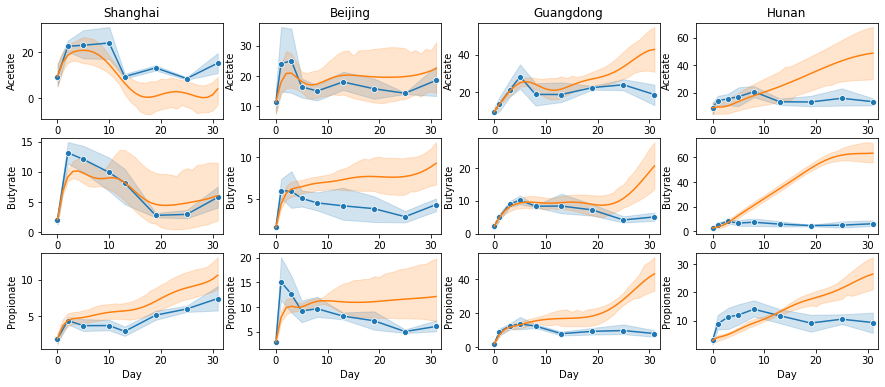

In [13]:
# plot prediction
fig, ax = plt.subplots(figsize=(15, 6), nrows=3, ncols=4)

for i,scfa in enumerate(['Acetate','Butyrate','Propionate']):
    for j,curr_vendor in enumerate(['Shanghai','Beijing','Guangdong','Hunan']):
        curr_df = df_pred[(df_pred.Vendor==curr_vendor)&(df_pred.SCFA==scfa)]
        sns.lineplot(x='Day',y='Observed', marker='o', data=curr_df, ax=ax[i,j])
        sns.lineplot(x='Day',y='Predicted',data=curr_df, ax=ax[i,j])
        if i==0:
            ax[i,j].set_title(curr_vendor)
        ax[i,j].set_ylabel(scfa)
        ax[i,j].set_xlim([-3.2,32])